In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
# Extracting data for ETH at 5 min interval. 
df_eth = pd.read_json('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1438992000&end=9999999999&period=300')
df_eth.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1.75,2015-08-08 06:15:00,1.75,1.61,1.65,45.000000,75.150000,1.67
1,1.85,2015-08-08 06:20:00,1.85,1.85,1.85,7.880354,14.578655,1.85
2,1.85,2015-08-08 06:25:00,1.85,1.85,1.85,0.160000,0.296000,1.85
3,1.85,2015-08-08 06:30:00,1.85,1.85,1.85,0.089794,0.166119,1.85
4,1.85,2015-08-08 06:35:00,1.85,1.85,1.85,0.000000,0.000000,1.85


In [7]:
df_eth.set_index('date', inplace=True)
df_eth.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08 06:15:00,1.75,1.75,1.61,1.65,45.000000,75.150000,1.67
2015-08-08 06:20:00,1.85,1.85,1.85,1.85,7.880354,14.578655,1.85
2015-08-08 06:25:00,1.85,1.85,1.85,1.85,0.160000,0.296000,1.85
2015-08-08 06:30:00,1.85,1.85,1.85,1.85,0.089794,0.166119,1.85
2015-08-08 06:35:00,1.85,1.85,1.85,1.85,0.000000,0.000000,1.85


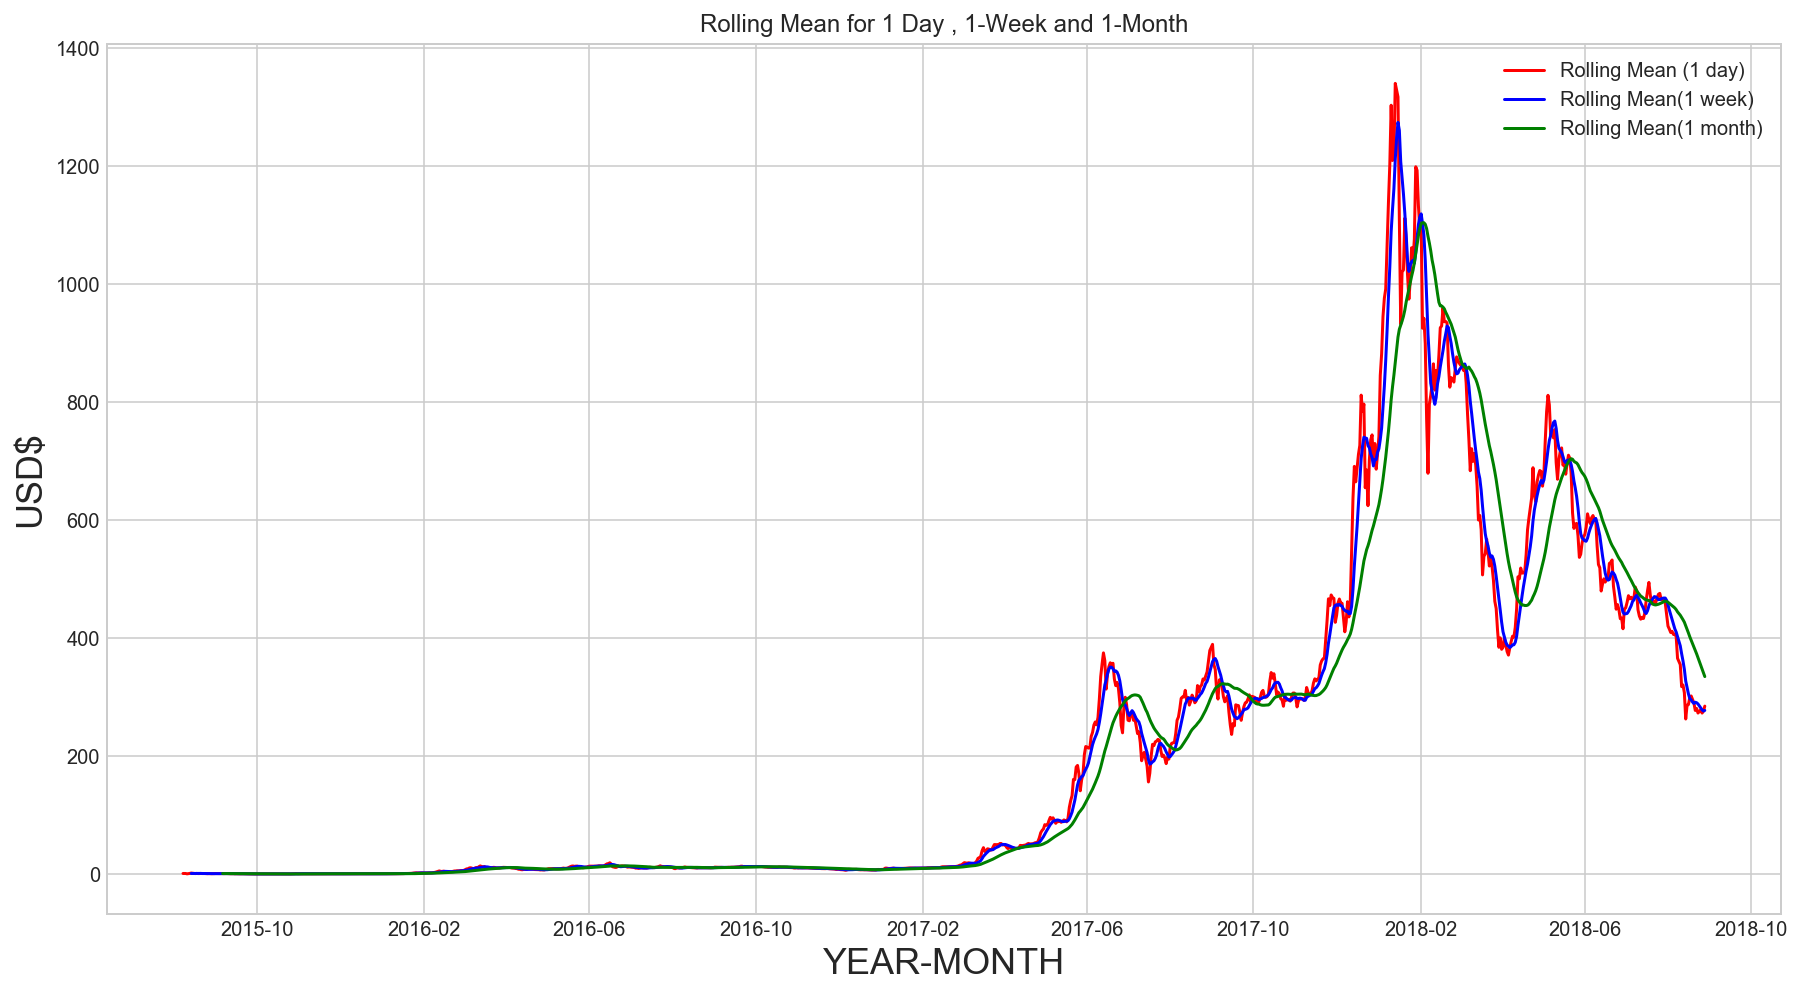

In [8]:
# Plotting the rolling mean for day, week, month.
df_eth_dailyclosemean = df_eth.close.resample('D').mean()

rolmean_1 = pd.rolling_mean(df_eth_dailyclosemean, window = 1)
rolmean_7 = pd.rolling_mean(df_eth_dailyclosemean, window = 7)
rolmean_30 = pd.rolling_mean(df_eth_dailyclosemean, window = 30)

fig = plt.figure(figsize=(15, 8))
mean = plt.plot(rolmean_1, color='red', label='Rolling Mean (1 day)')
mean = plt.plot(rolmean_7, color='blue', label='Rolling Mean(1 week)')
mean = plt.plot(rolmean_30, color='green', label='Rolling Mean(1 month)')

plt.legend(loc='best')
plt.title('Rolling Mean for 1 Day , 1-Week and 1-Month')
plt.ylabel('USD$', fontsize=18)
plt.xlabel('YEAR-MONTH', fontsize=18)
plt.show()

### Resample to weekly

In [9]:
df_eth_weeklyclosemean = df_eth.close.resample('W').mean()
df_eth_weeklyclosemean.head()

date
2015-08-09    1.423633
2015-08-16    1.453390
2015-08-23    1.376518
2015-08-30    1.165105
2015-09-06    1.262006
Freq: W-SUN, Name: close, dtype: float64

In [10]:
df_eth_weeklyclosemean.tail()

date
2018-08-05    423.572927
2018-08-12    361.685338
2018-08-19    292.035617
2018-08-26    278.740955
2018-09-02    278.704410
Freq: W-SUN, Name: close, dtype: float64

In [11]:
df_eth_weeklyclosemean.index

DatetimeIndex(['2015-08-09', '2015-08-16', '2015-08-23', '2015-08-30',
               '2015-09-06', '2015-09-13', '2015-09-20', '2015-09-27',
               '2015-10-04', '2015-10-11',
               ...
               '2018-07-01', '2018-07-08', '2018-07-15', '2018-07-22',
               '2018-07-29', '2018-08-05', '2018-08-12', '2018-08-19',
               '2018-08-26', '2018-09-02'],
              dtype='datetime64[ns]', name=u'date', length=161, freq='W-SUN')

In [12]:
df_eth_weeklyclosemean.shape

(161,)

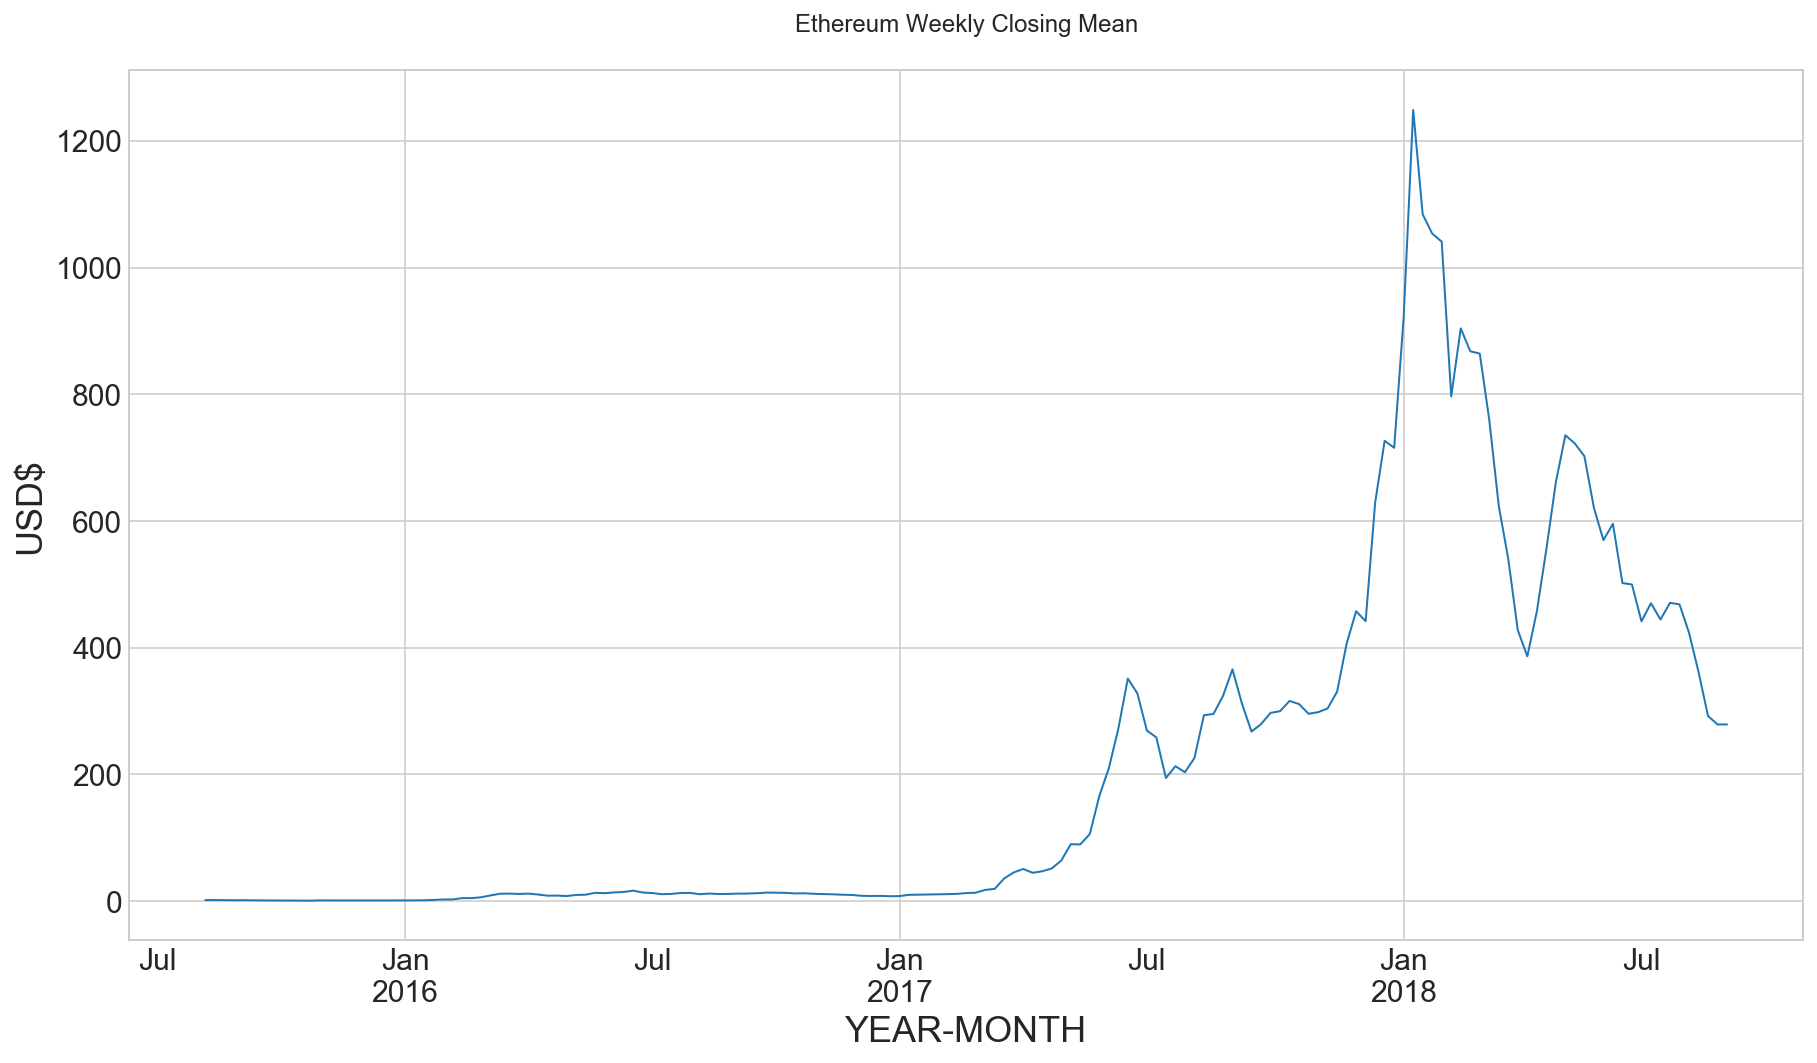

In [13]:
df_eth_weeklyclosemean.plot(kind='line', lw='1.0', figsize=(15,8), title= 'Ethereum Weekly Closing Mean\n',  fontsize=15)
plt.ylabel('USD$', fontsize=18)
plt.xlabel('YEAR-MONTH', fontsize=18)
plt.show()

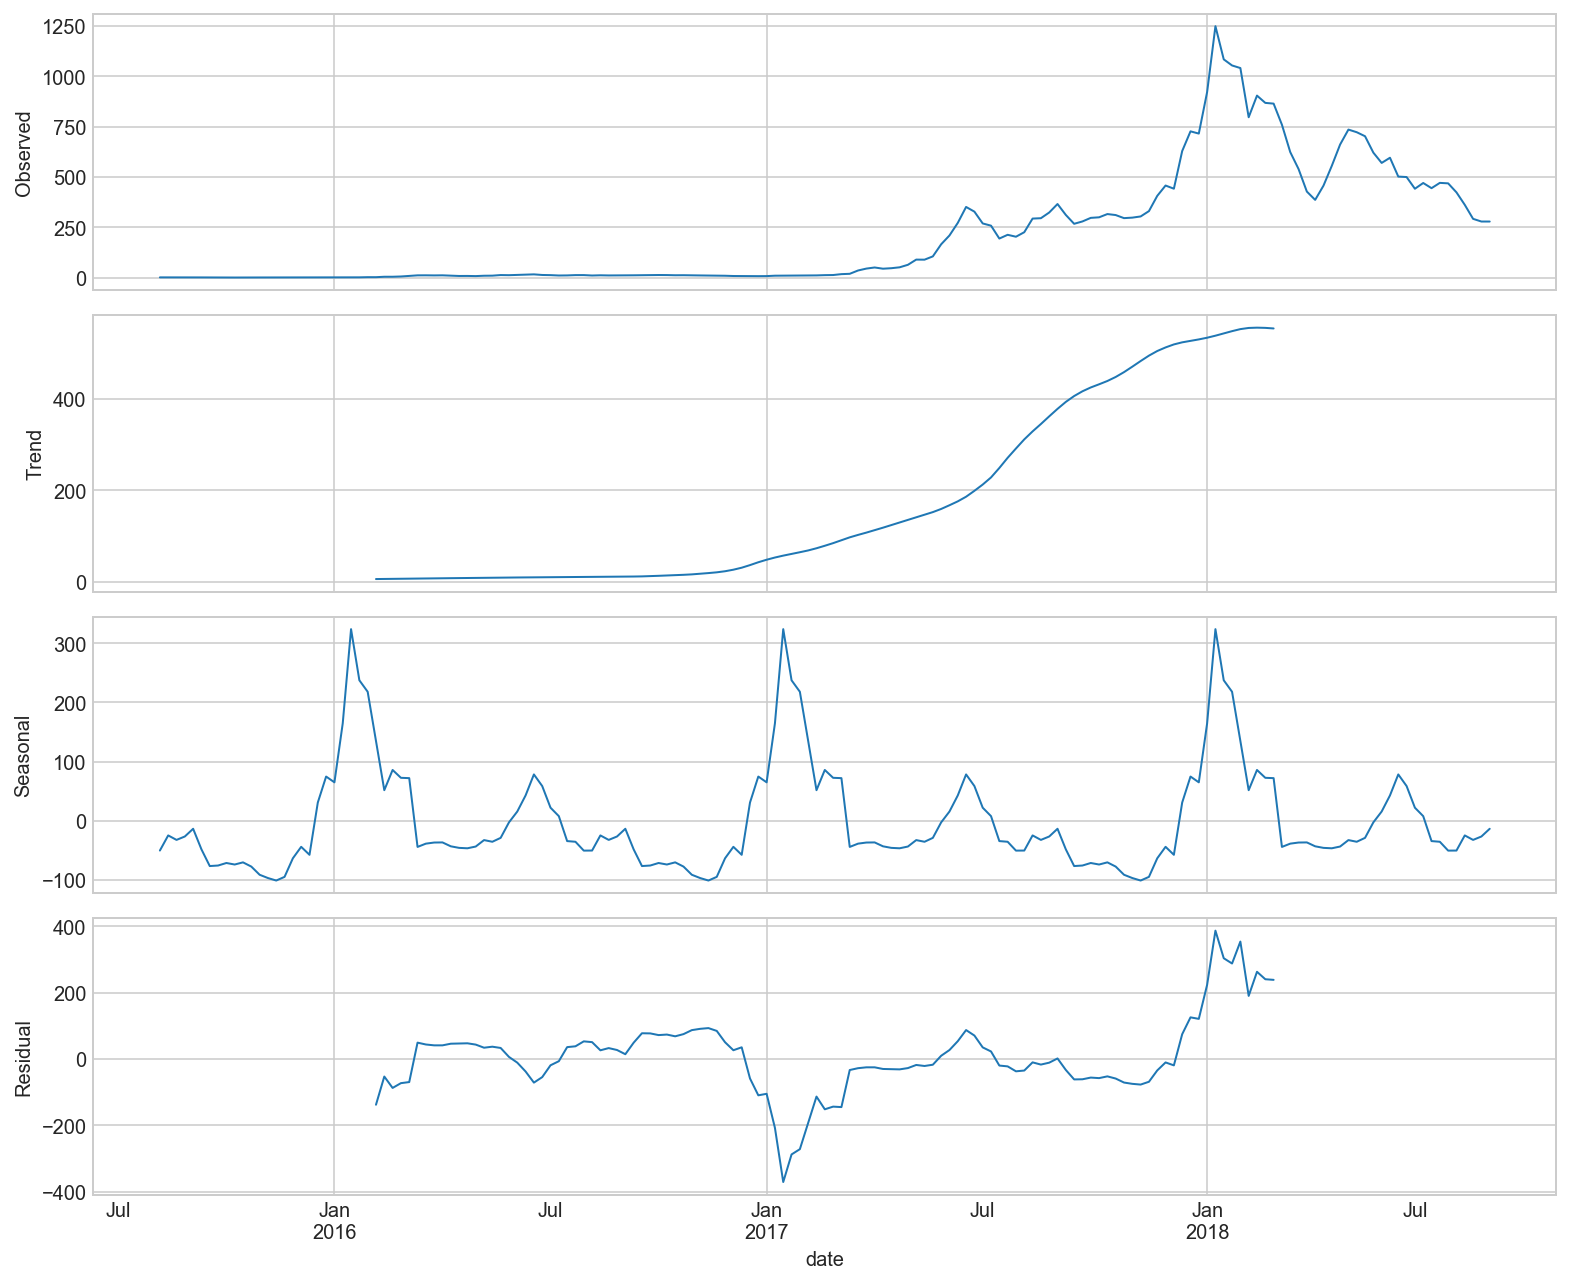

In [14]:
# Additive decomposition for non-log values. 
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
rcParams['lines.linewidth'] = 1.0

series = df_eth_weeklyclosemean
decomposition = seasonal_decompose(series, model='additive')
fig = decomposition.plot()
plt.show()

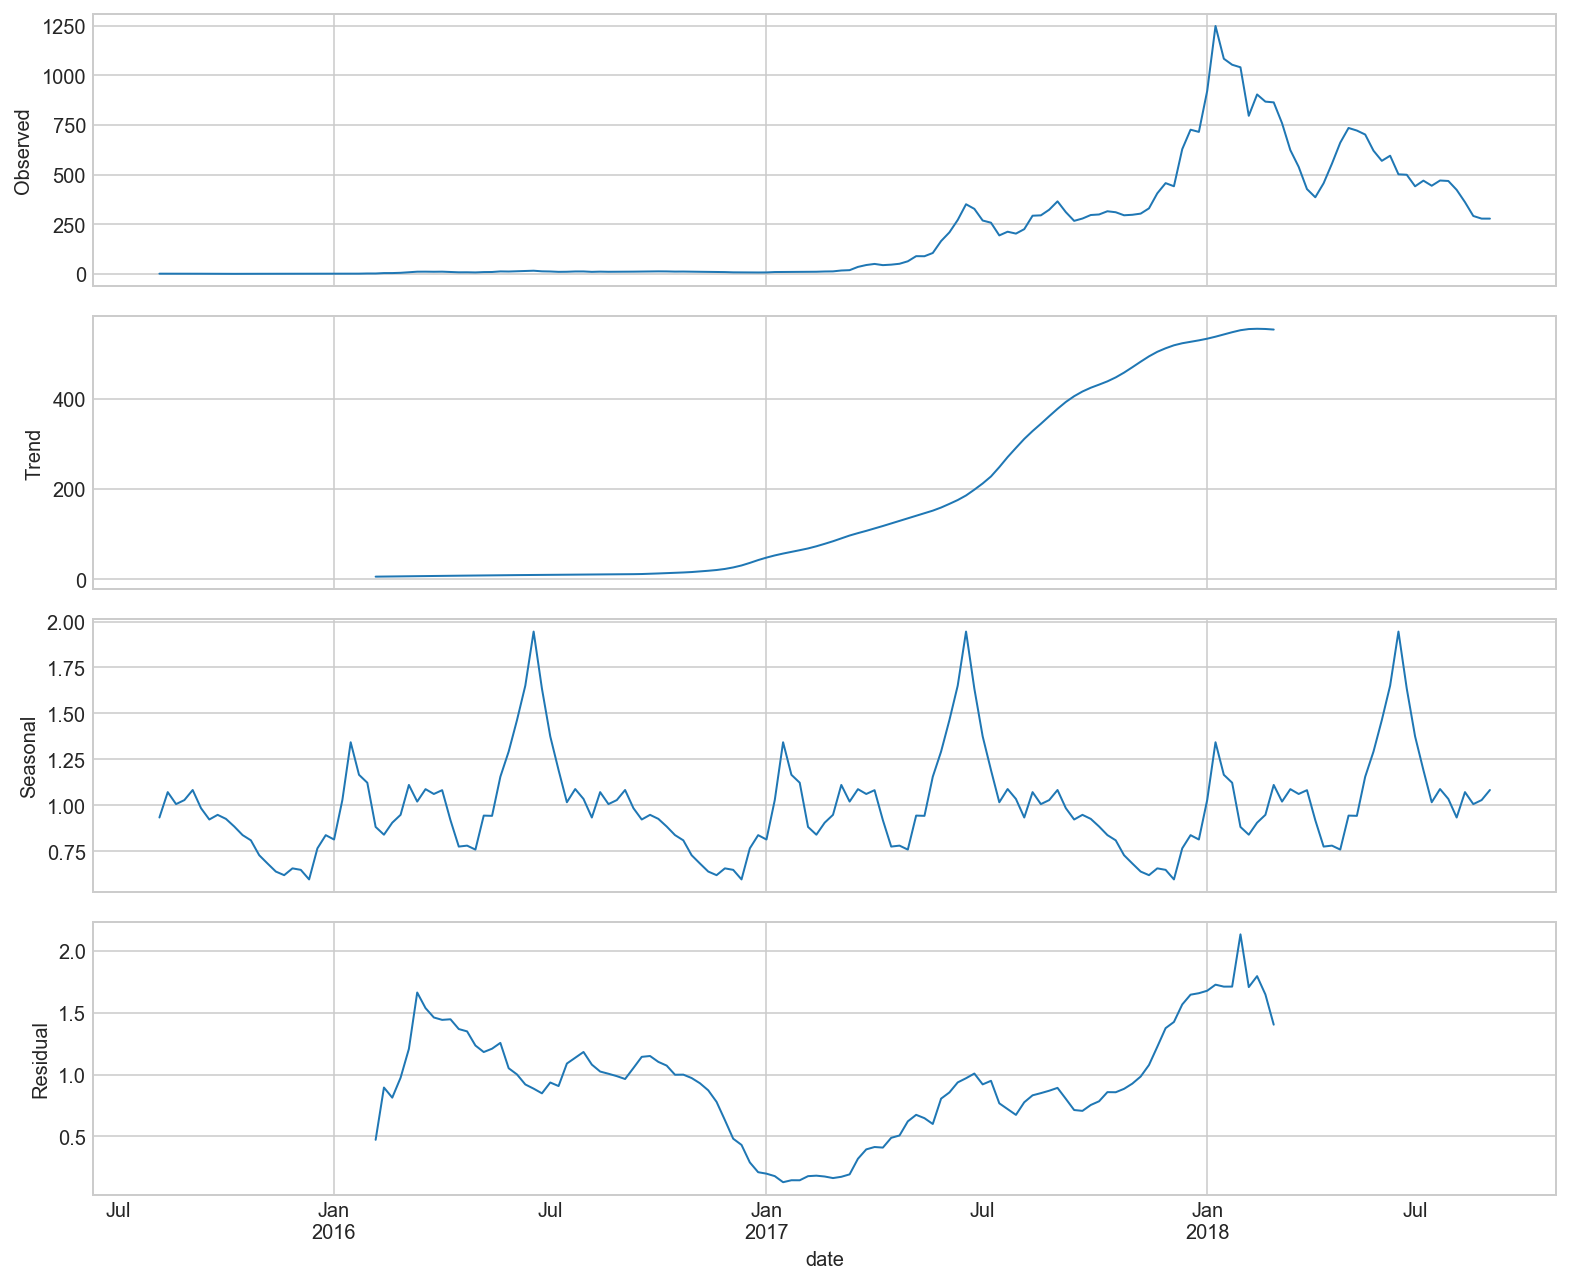

In [15]:
# Multiplicative decomposition for non-log values. 
series = df_eth_weeklyclosemean
decomposition = seasonal_decompose(series, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [16]:
# Testing for Stationarity
# p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

# Define a Dickey-Fuller test.

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

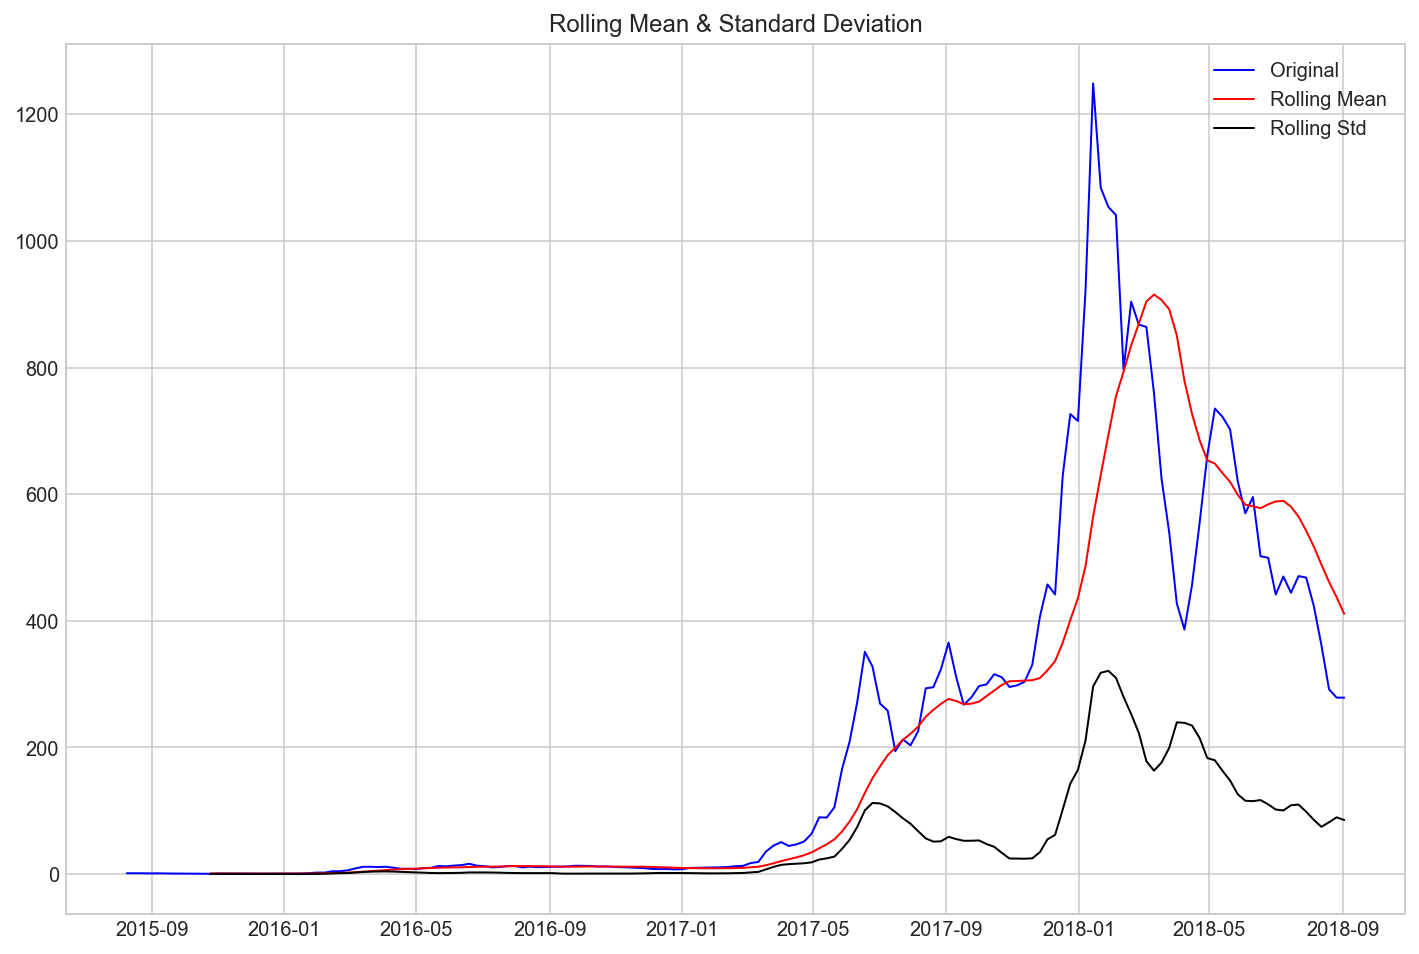

Results of Dickey-Fuller Test:
Test Statistic                  -1.184884
p-value                          0.680064
#Lags Used                      10.000000
Number of Observations Used    150.000000
Critical Value (5%)             -2.881009
Critical Value (1%)             -3.474715
Critical Value (10%)            -2.577151
dtype: float64


In [17]:
test_stationarity(df_eth_weeklyclosemean)

#### p > 0.05 , so we do a first differencing and test for stationarity again.

In [18]:
series_diff = df_eth_weeklyclosemean.diff()

In [19]:
series_diff.dropna(inplace=True)
series_diff.head()

date
2015-08-16    0.029758
2015-08-23   -0.076872
2015-08-30   -0.211413
2015-09-06    0.096901
2015-09-13   -0.078985
Freq: W-SUN, Name: close, dtype: float64

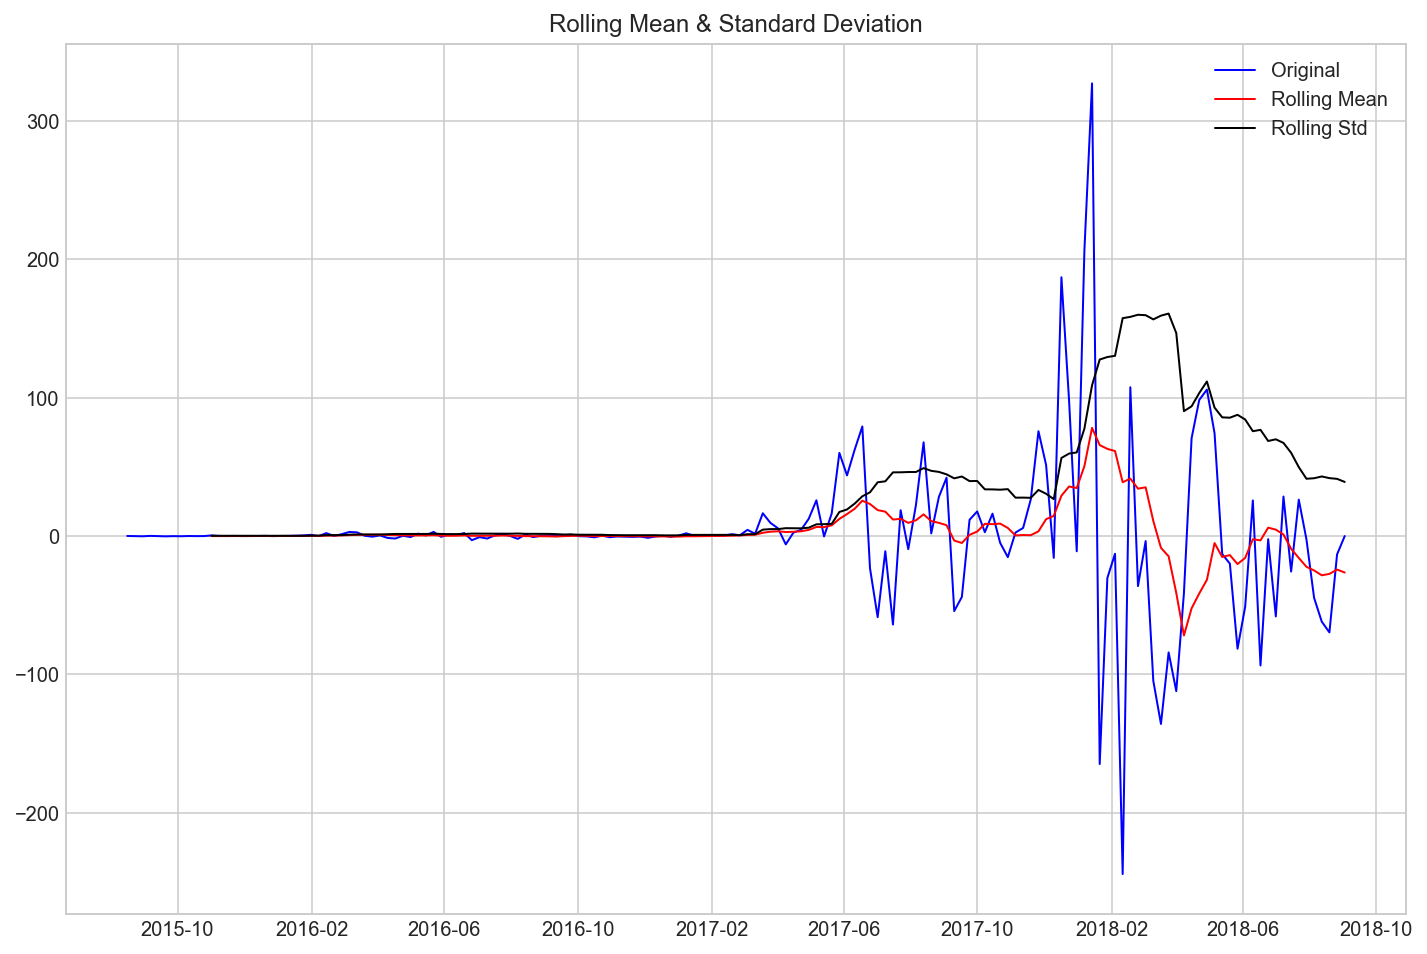

Results of Dickey-Fuller Test:
Test Statistic                  -4.853720
p-value                          0.000043
#Lags Used                       9.000000
Number of Observations Used    150.000000
Critical Value (5%)             -2.881009
Critical Value (1%)             -3.474715
Critical Value (10%)            -2.577151
dtype: float64


In [20]:
test_stationarity(series_diff)

### Create ACF and PACF on the first differenced time series

By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, we can tentatively identify the numbers of AR and/or MA terms that are needed. The ACF plot is merely a bar chart of the coefficients of correlation between a time series and lags of itself. The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

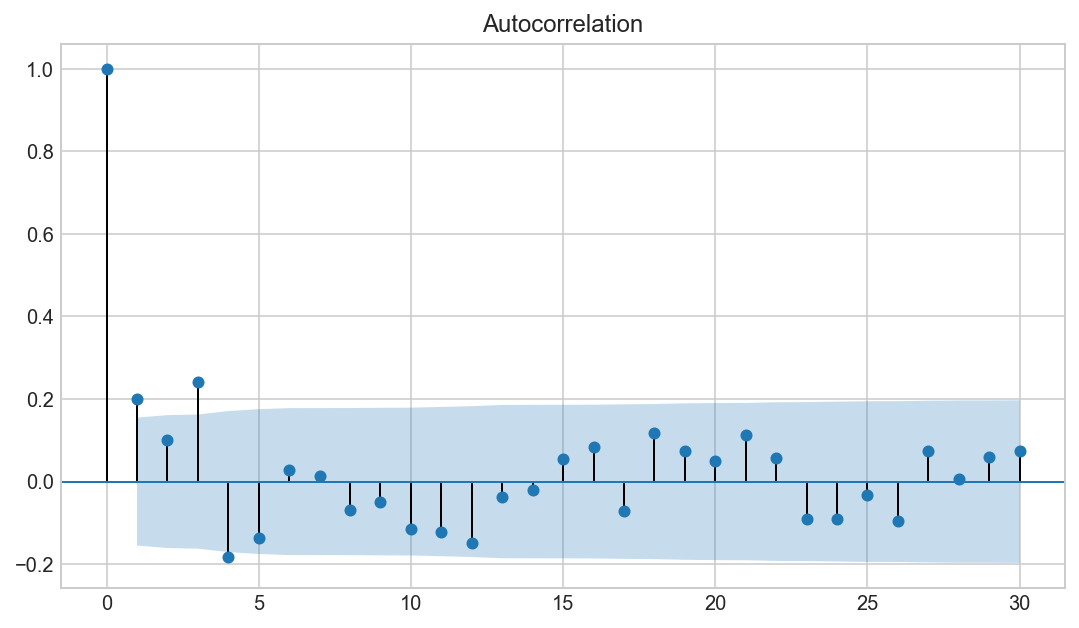

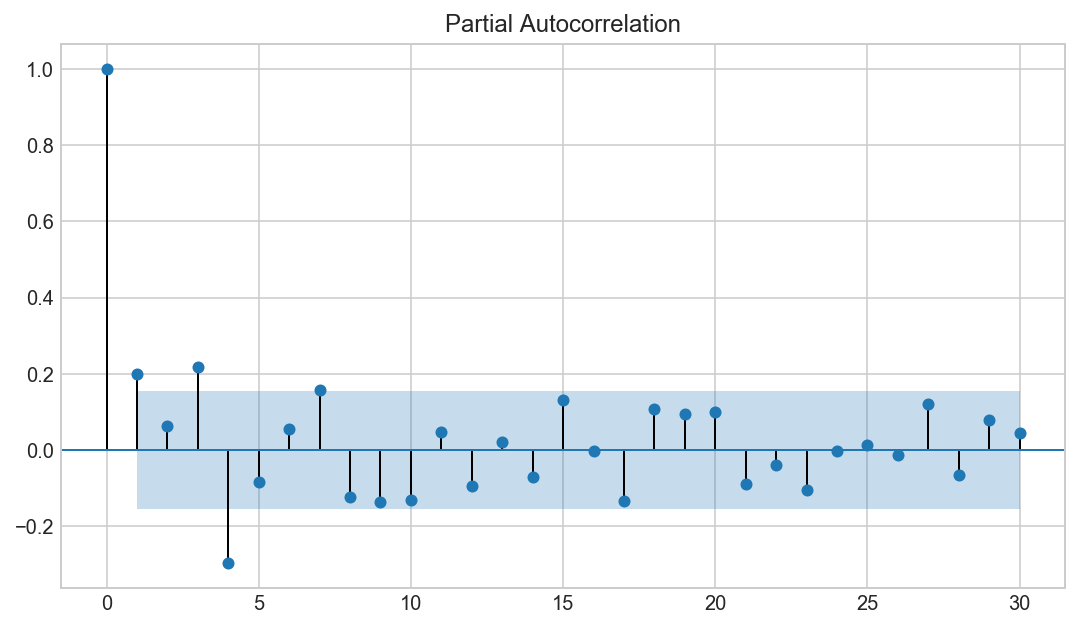

In [21]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(series_diff, lags=30, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(series_diff, lags=30, ax=ax)
plt.show()

### ARMA model

In [22]:
ar1ma1 = ARMA(series_diff, (1, 1)).fit()
ar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                  160
Model:                     ARMA(1, 1)   Log Likelihood                -860.425
Method:                       css-mle   S.D. of innovations             52.381
Date:                Tue, 28 Aug 2018   AIC                           1728.850
Time:                        16:11:38   BIC                           1741.151
Sample:                    08-16-2015   HQIC                          1733.845
                         - 09-02-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6727      5.833      0.287      0.775      -9.760      13.105
ar.L1.close     0.5511      0.201      2.747      0.007       0.158       0.944
ma.L1.close    -0.3652      0.218     -1.678      0.095      -0.792       0.061
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8144           +0.0000j            1.8144            0.0000
MA.1            2.7379           +0.0000j            2.7379            0.0000
-----------------------------------------------------------------------------
"""

#### In-Sample Predictions

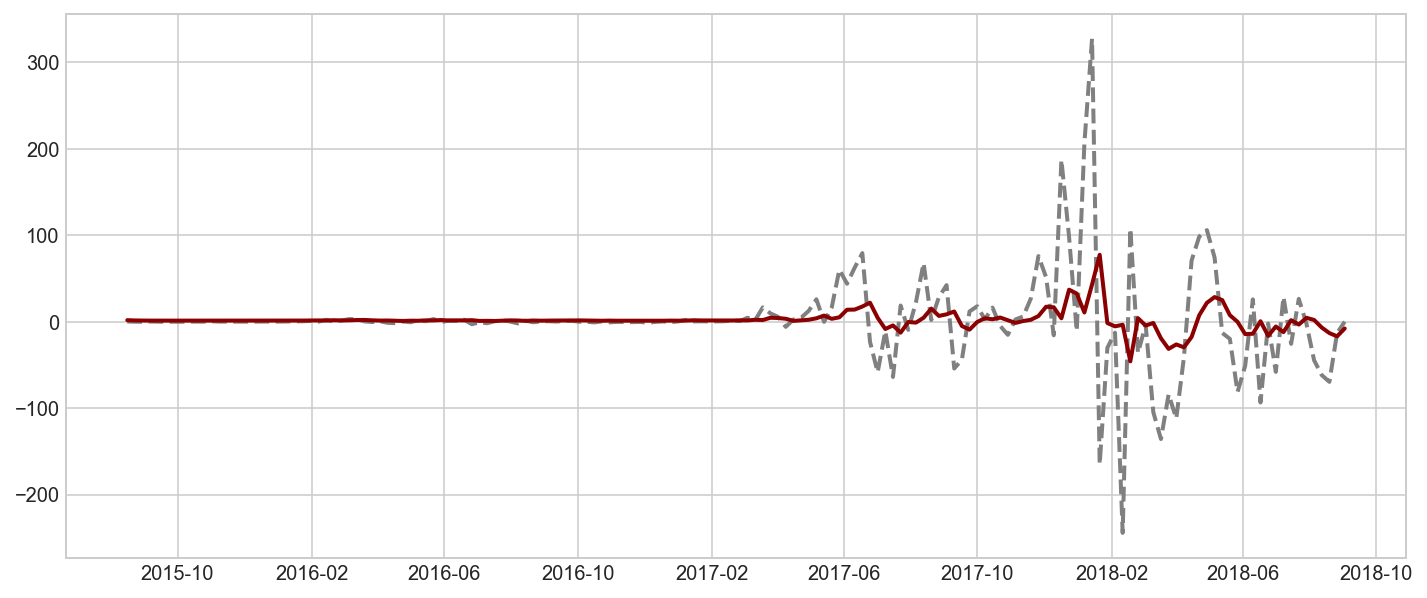

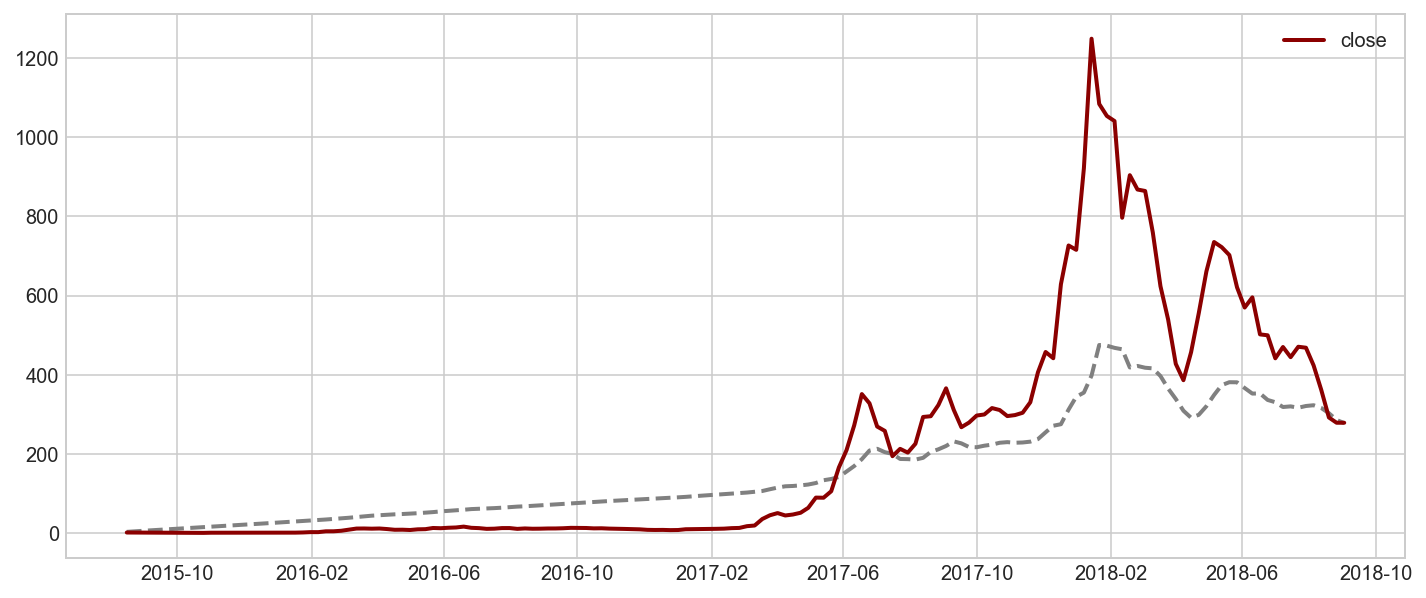

In [23]:
predictions = ar1ma1.predict()
full_pred = df_eth_weeklyclosemean.values[0]+np.cumsum(ar1ma1.fittedvalues)

date_ticks = df_eth_weeklyclosemean.index


fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks[1:], series_diff, lw=2, color='grey', ls='dashed',label='Data')
ax.plot(date_ticks[1:], predictions, lw=2, color='darkred',label='Fit')
plt.show()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks[1:], full_pred, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks[1:], df_eth_weeklyclosemean[1:], lw=2, color='darkred')

plt.legend()
plt.show()

In [24]:
r2_score(series_diff, ar1ma1.fittedvalues)

0.04805171445349654

#### Out-Sample Predictions

In [25]:
len(df_eth_weeklyclosemean)

161

In [26]:
date_ticks.shape

(161,)

In [31]:
series_diff.tail()

date
2018-08-05   -44.715909
2018-08-12   -61.887589
2018-08-19   -69.649720
2018-08-26   -13.294662
2018-09-02    -0.036545
Freq: W-SUN, Name: close, dtype: float64

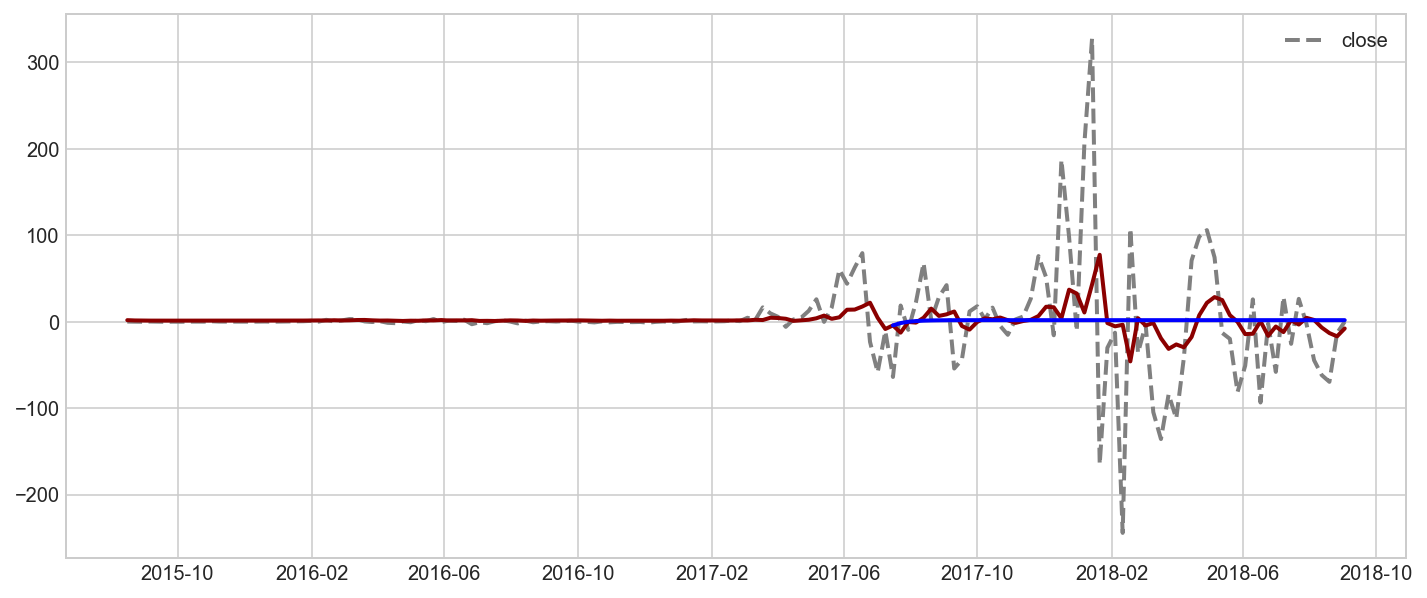

In [50]:
predictions_oos = ar1ma1.predict(start=100, dynamic=True)
#predictions_oos = ar1ma1.predict(start=pd.to_datetime('2018-08-19'), end='2018-12-19', dynamic=False)
#predictions_oos = ar1ma1.predict(start=158, end=200, dynamic=False)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks[1:], series_diff, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks[1:], predictions, lw=2, color='darkred')
ax.plot(date_ticks[101:], predictions_oos, lw=2, color='blue')
plt.legend()
plt.show()

In [51]:
date_ticks[160:]

DatetimeIndex(['2018-09-02'], dtype='datetime64[ns]', name=u'date', freq='W-SUN')

In [52]:
date_ticks[101:]

DatetimeIndex(['2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
               '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24',
               '2017-12-31', '2018-01-07', '2018-01-14', '2018-01-21',
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15',
               '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
               '2018-06-17', '2018-06-24', '2018-07-01', '2018-07-08',
               '2018-07-15', '2018-07-22', '2018-07-29', '2018-08-05',
      

In [53]:
date_ticks[1:]

DatetimeIndex(['2015-08-16', '2015-08-23', '2015-08-30', '2015-09-06',
               '2015-09-13', '2015-09-20', '2015-09-27', '2015-10-04',
               '2015-10-11', '2015-10-18',
               ...
               '2018-07-01', '2018-07-08', '2018-07-15', '2018-07-22',
               '2018-07-29', '2018-08-05', '2018-08-12', '2018-08-19',
               '2018-08-26', '2018-09-02'],
              dtype='datetime64[ns]', name=u'date', length=160, freq='W-SUN')

In [56]:
predictions_oos.head()

2017-07-16   -4.415639
2017-07-23   -1.682887
2017-07-30   -0.176737
2017-08-06    0.653373
2017-08-13    1.110886
Freq: W-SUN, dtype: float64

In [58]:
predictions_oos.tail()

2018-08-05    1.672668
2018-08-12    1.672668
2018-08-19    1.672668
2018-08-26    1.672668
2018-09-02    1.672668
Freq: W-SUN, dtype: float64

#### Reconstructing the full prediction

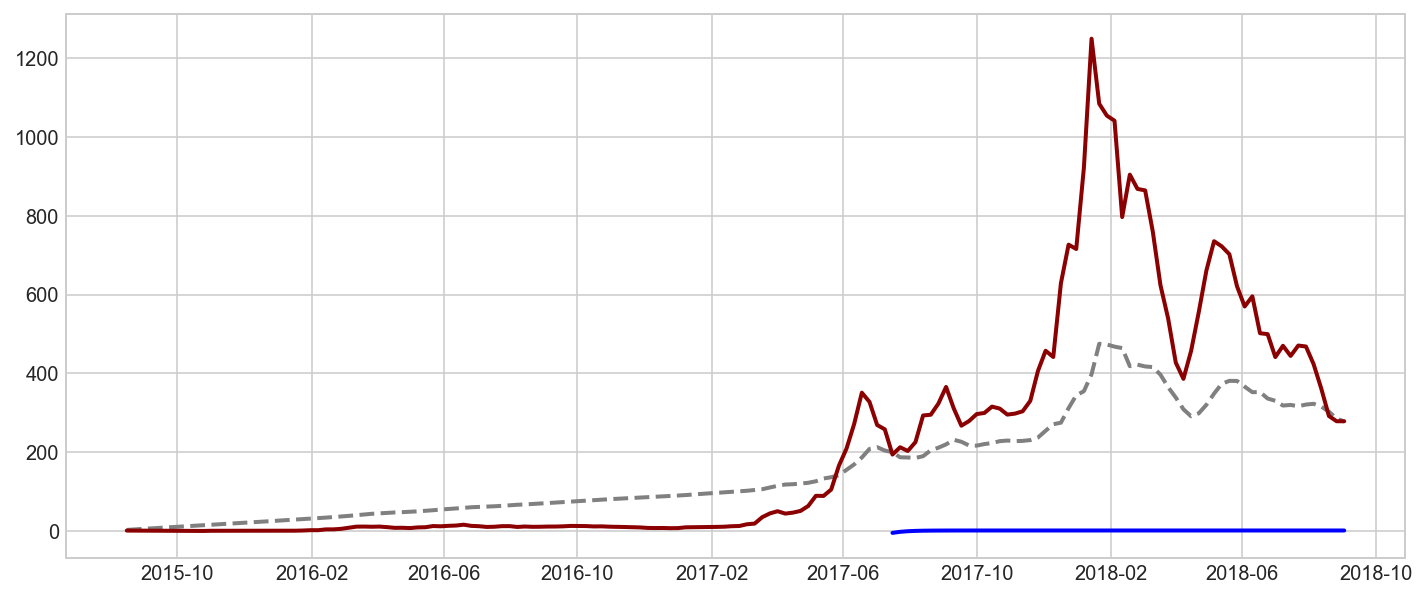

In [62]:
full_pred = df_eth_weeklyclosemean.values[0]+np.cumsum(ar1ma1.fittedvalues)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks[1:], full_pred, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks[1:], df_eth_weeklyclosemean[1:], lw=2, color='darkred')
ax.plot(date_ticks[101:], predictions_oos, lw=2, color='blue')
plt.show()

The training period mostly consists of periods when cryptos were relatively cheaper. As such, the training data may not be representative of the test data, undermining the model’s ability to generalise to unseen data

One simple approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a 
model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than 
similar models that utilize more features.
The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object 
that you can fit to the training data.
https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

### Using Step-wise modeling via Auto-Arima

In [83]:
# Auto Arima
stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1659.879, BIC=1672.154, Fit time=1.622 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1705.516, BIC=1714.722, Fit time=0.174 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=1614.224, BIC=1629.569, Fit time=0.873 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=1611.960, BIC=1633.442, Fit time=3.099 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=1614.712, BIC=1633.126, Fit time=2.846 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=1613.237, BIC=1

The output of our code suggests that using the model SARIMAX(1, 1, 1)x(1, 1, 1, 12) which yields the lowest AIC value of 1600.029. We should therefore consider this to be optimal option out of all the models we have considered.

#### Note on AIC/BIC being negative values 
The actual value of the AIC (or AICc), and whether it is positive or negative, means nothing. If you simply changed the units the data are expressed in, the AIC (and AICc) would change dramatically. But the difference between the AIC of the two alternative models would not change at all.

Bottom line: Ignore whether it is positive or negative. Just choose the smallest which is the most optimal for the case. 

In [84]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  159
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -795.498
Date:                            Mon, 13 Aug 2018   AIC                           1604.996
Time:                                    11:32:05   BIC                           1626.478
Sample:                                         0   HQIC                          1613.719
                                            - 159                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7833      3.066      0.582      0.561      -4.225       7.792
ar.L1         -0.6370      0.073     -8.691      0.000      -0.781      -0.493
ma.L1          0.8813      0.055     15.932      0.000       0.773       0.990
ar.S.L12      -0.3909      0.153     -2.562      0.010      -0.690      -0.092
ar.S.L24      -0.3958      0.158     -2.501      0.012      -0.706      -0.086
ma.S.L12      -0.6778      0.154     -4.398      0.000      -0.980      -0.376
sigma2      2649.0660    148.442     17.846      0.000    2358.125    2940.007
===================================================================================
Ljung-Box (Q):                       39.07   Jarque-Bera (JB):               491.61
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):            2909.37   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Reading the Summary Output

#### Interpreting the model summary

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model. The Jarque-Bera test is a goodness-of-fit test of whether the data has the skewness and kurtosis of a normal distribution. The normal distribution has a skew of 1.35 and a kurtosis of 4.96.

In [85]:
model = sm.tsa.statespace.SARIMAX(series, 
                                  order=(1,1,1), 
                                  seasonal_order=(1,1,1,12))
results = model.fit()

print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                  159
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -799.491
Date:                            Mon, 13 Aug 2018   AIC                           1608.981
Time:                                    11:32:10   BIC                           1624.326
Sample:                                08-09-2015   HQIC                          1615.213
                                     - 08-19-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6510      0.080     -8.128      0.000      -0.808      -0.494
ma.L1          0.8701      0.063   

#### Plot model diagnostics

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

We need to ensure that the residuals of our model are randomly distributed with zero-mean and not serially correlate, i. e. we’d like the remaining information to be white noise. If the fitted seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The residual plot of the fitted model in the upper left corner appears do be white noise as it does not display obvious seasonality or trend behaviour. The histogram plot in the upper right corner pair with the kernel density estimation (red line) indicates that the time series is almost normally distributed. This is compared to the density of the standard normal distribution (green line). The correlogram (autocorrelation plot) confirms this resuts, since the time series residuals show low correlations with lagged residuals.

Although the fit so far appears to be fine, a better fit could be achieved with a more complex model.

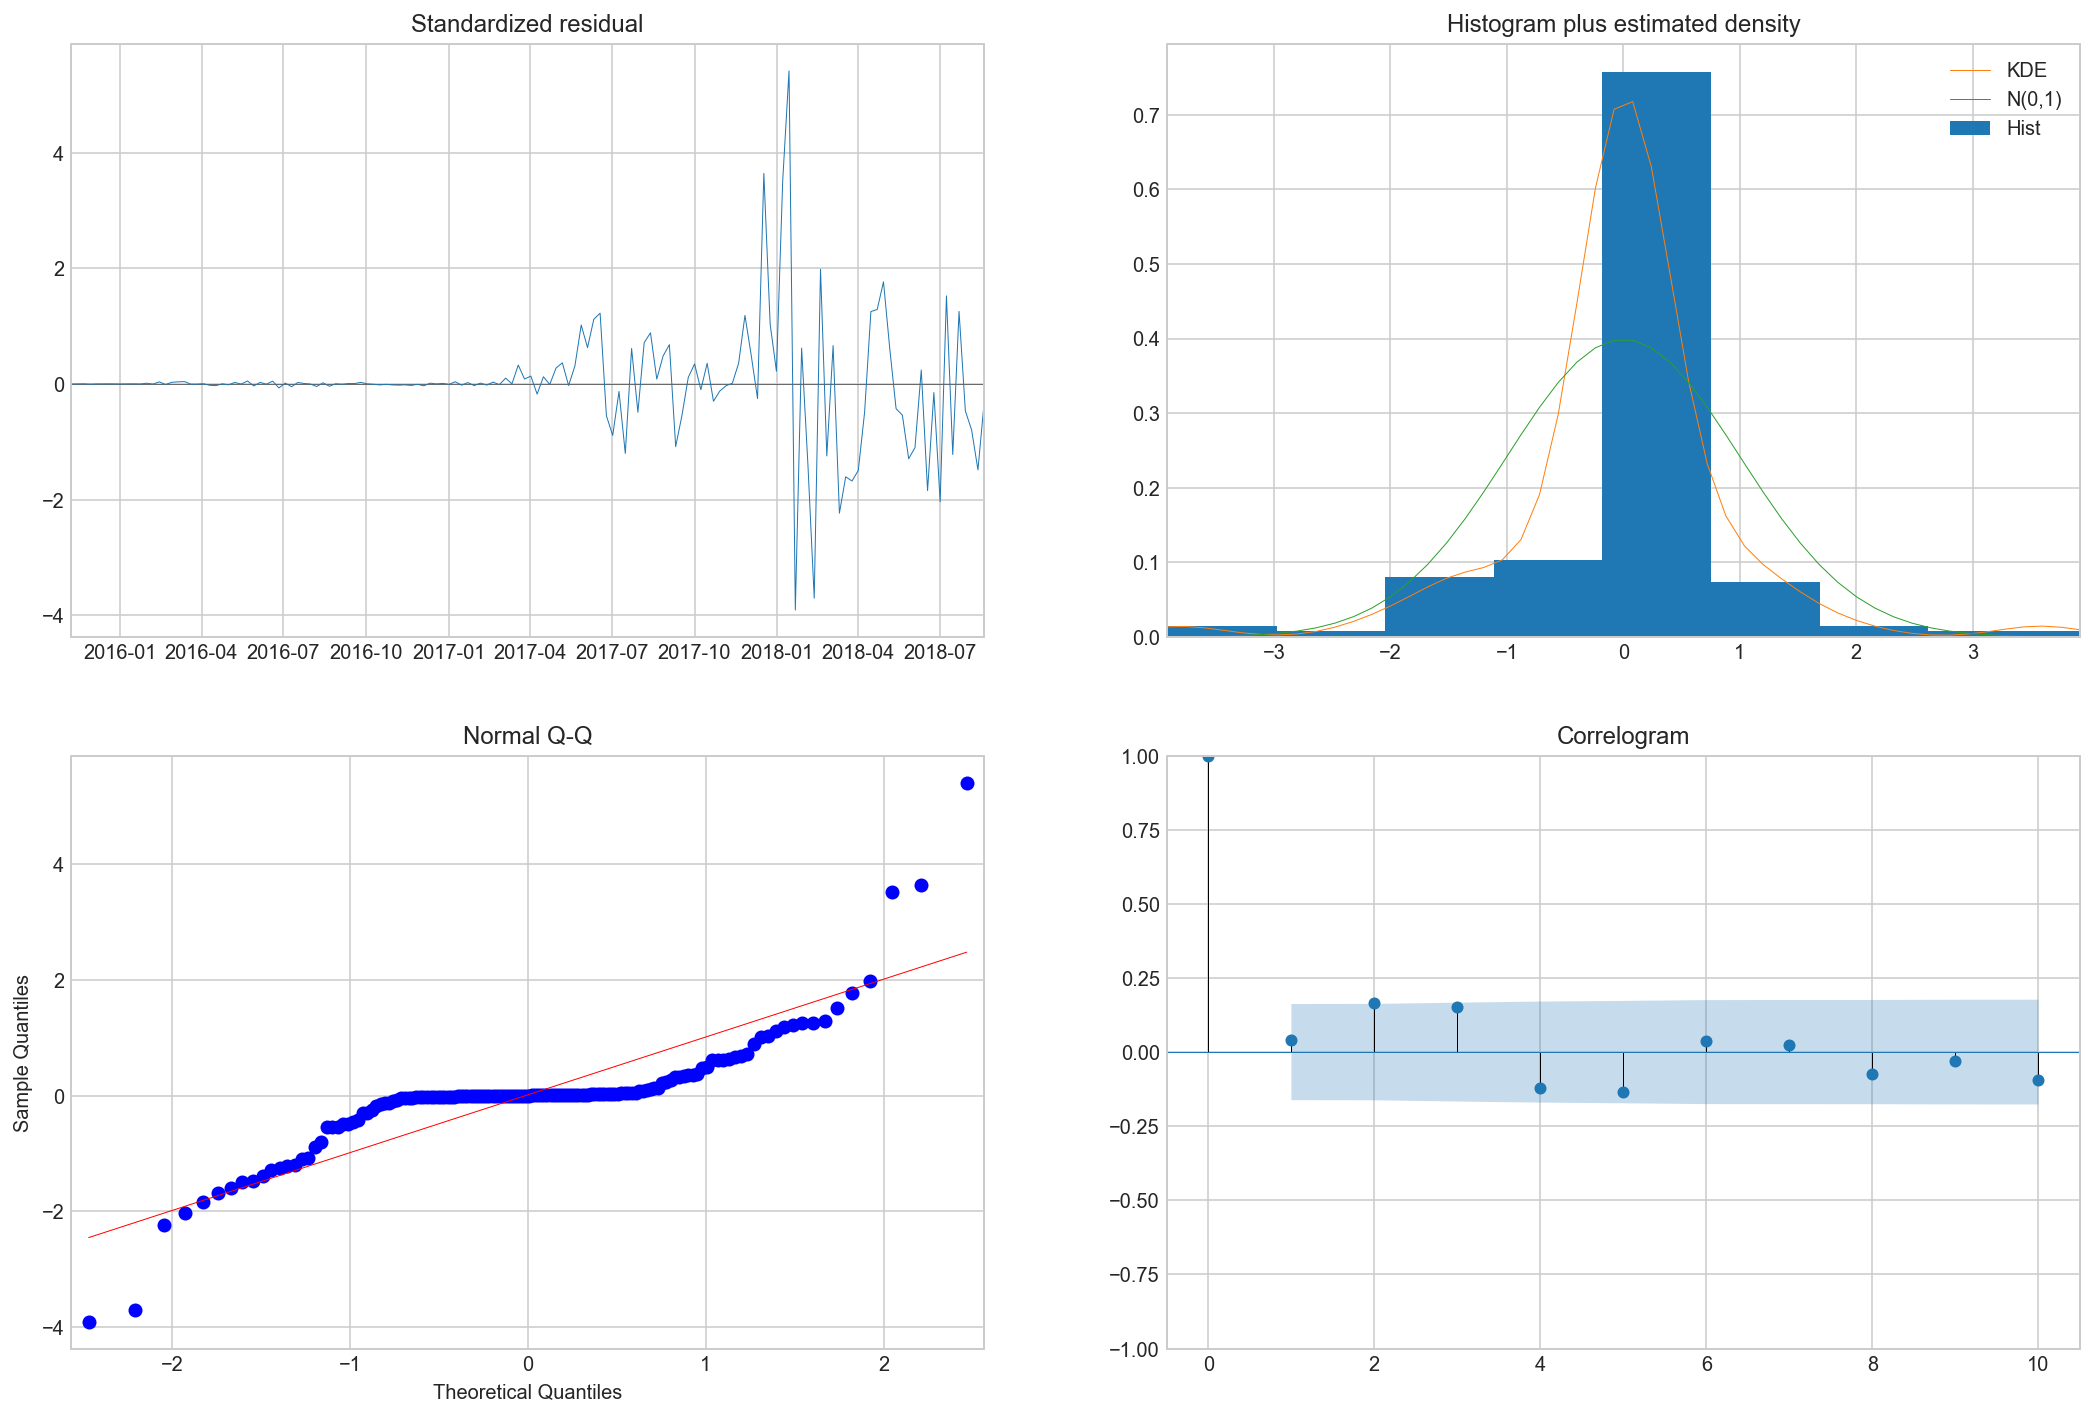

In [86]:
results.plot_diagnostics(figsize=(18, 12))
plt.show()

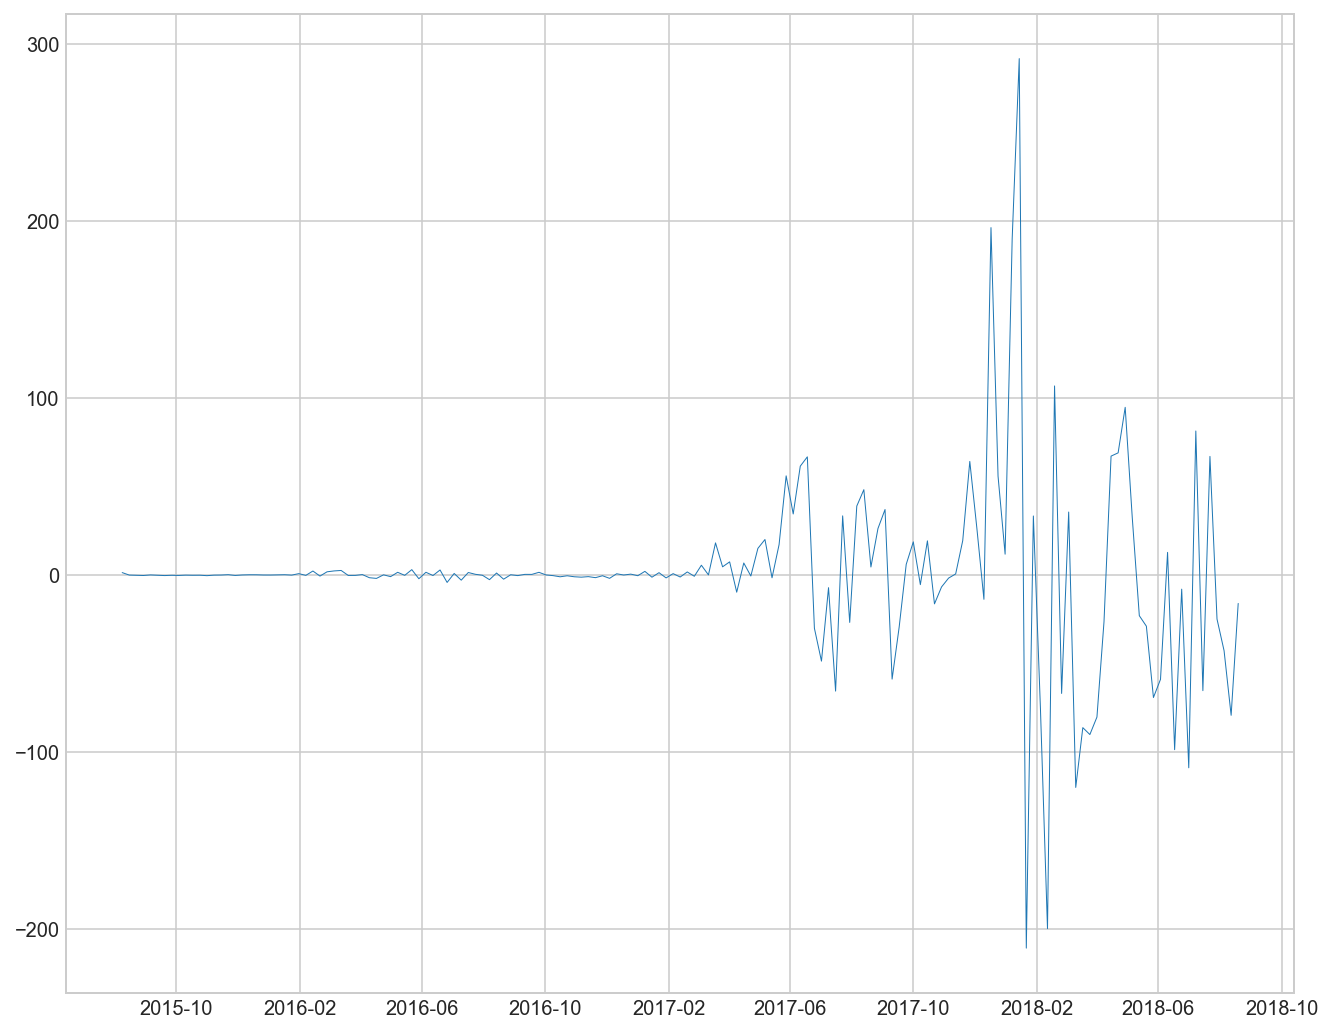

In [87]:
residuals = results.resid
plt.plot(residuals)

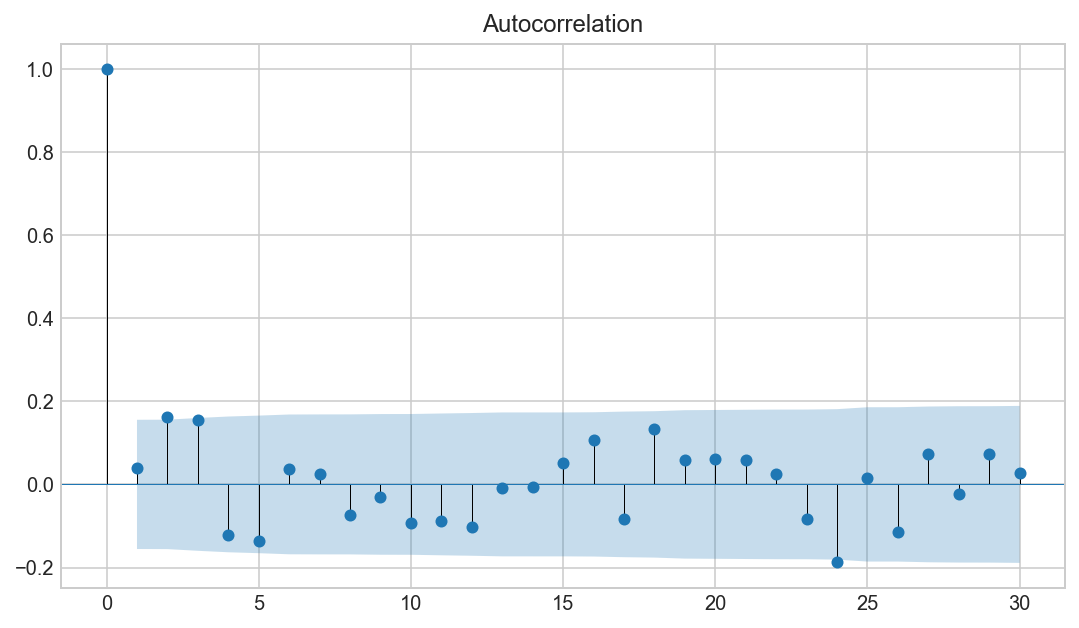

In [88]:
# Plot the ACF and PACF of the residuals
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()
# autocorrelation found , means when we decompose the original series some of the signal has remained in the residuals.
# if have time can tuned more to remove autocorr

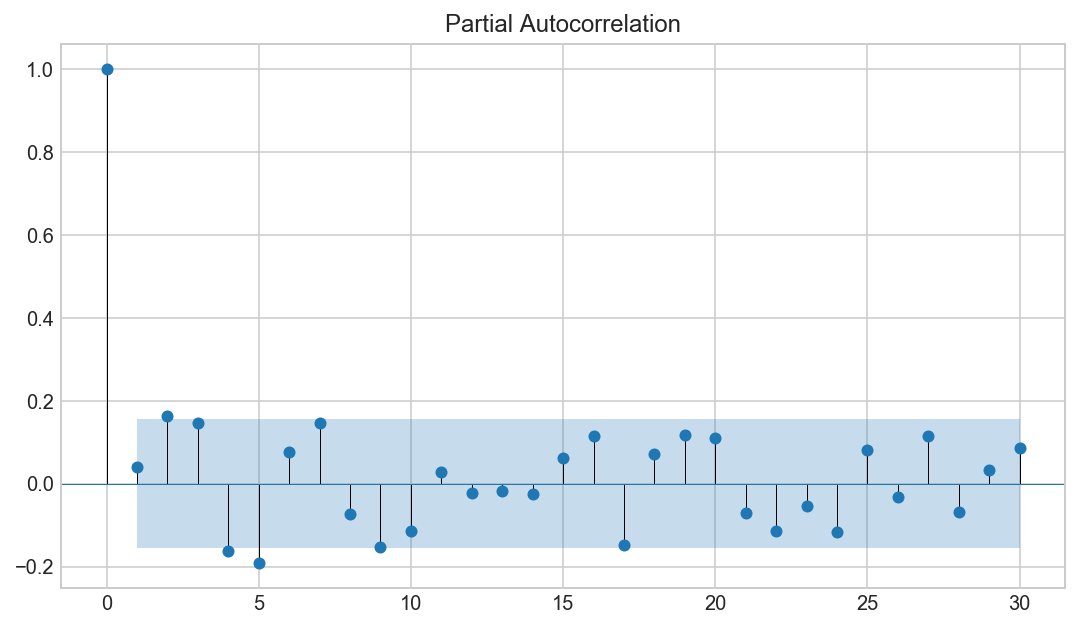

In [89]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()
# each point against the first.

In [90]:
pd.options.display.max_seq_items = 2000
series.index

DatetimeIndex(['2015-08-09', '2015-08-16', '2015-08-23', '2015-08-30',
               '2015-09-06', '2015-09-13', '2015-09-20', '2015-09-27',
               '2015-10-04', '2015-10-11', '2015-10-18', '2015-10-25',
               '2015-11-01', '2015-11-08', '2015-11-15', '2015-11-22',
               '2015-11-29', '2015-12-06', '2015-12-13', '2015-12-20',
               '2015-12-27', '2016-01-03', '2016-01-10', '2016-01-17',
               '2016-01-24', '2016-01-31', '2016-02-07', '2016-02-14',
               '2016-02-21', '2016-02-28', '2016-03-06', '2016-03-13',
               '2016-03-20', '2016-03-27', '2016-04-03', '2016-04-10',
               '2016-04-17', '2016-04-24', '2016-05-01', '2016-05-08',
               '2016-05-15', '2016-05-22', '2016-05-29', '2016-06-05',
               '2016-06-12', '2016-06-19', '2016-06-26', '2016-07-03',
               '2016-07-10', '2016-07-17', '2016-07-24', '2016-07-31',
               '2016-08-07', '2016-08-14', '2016-08-21', '2016-08-28',
      

The get_prediction and conf_int methods calculate predictions for future points in time for the previously fitted model and the confidence intervals associated with a prediction, respectively. The dynamic=False argument causes the method to produce a one-step ahead prediction of the time series

If you are forecasting for an observation that was part of the data sample - it is in-sample forecast.
If you are forecasting for an observation that was not part of the data sample - it is out-of-sample forecast.



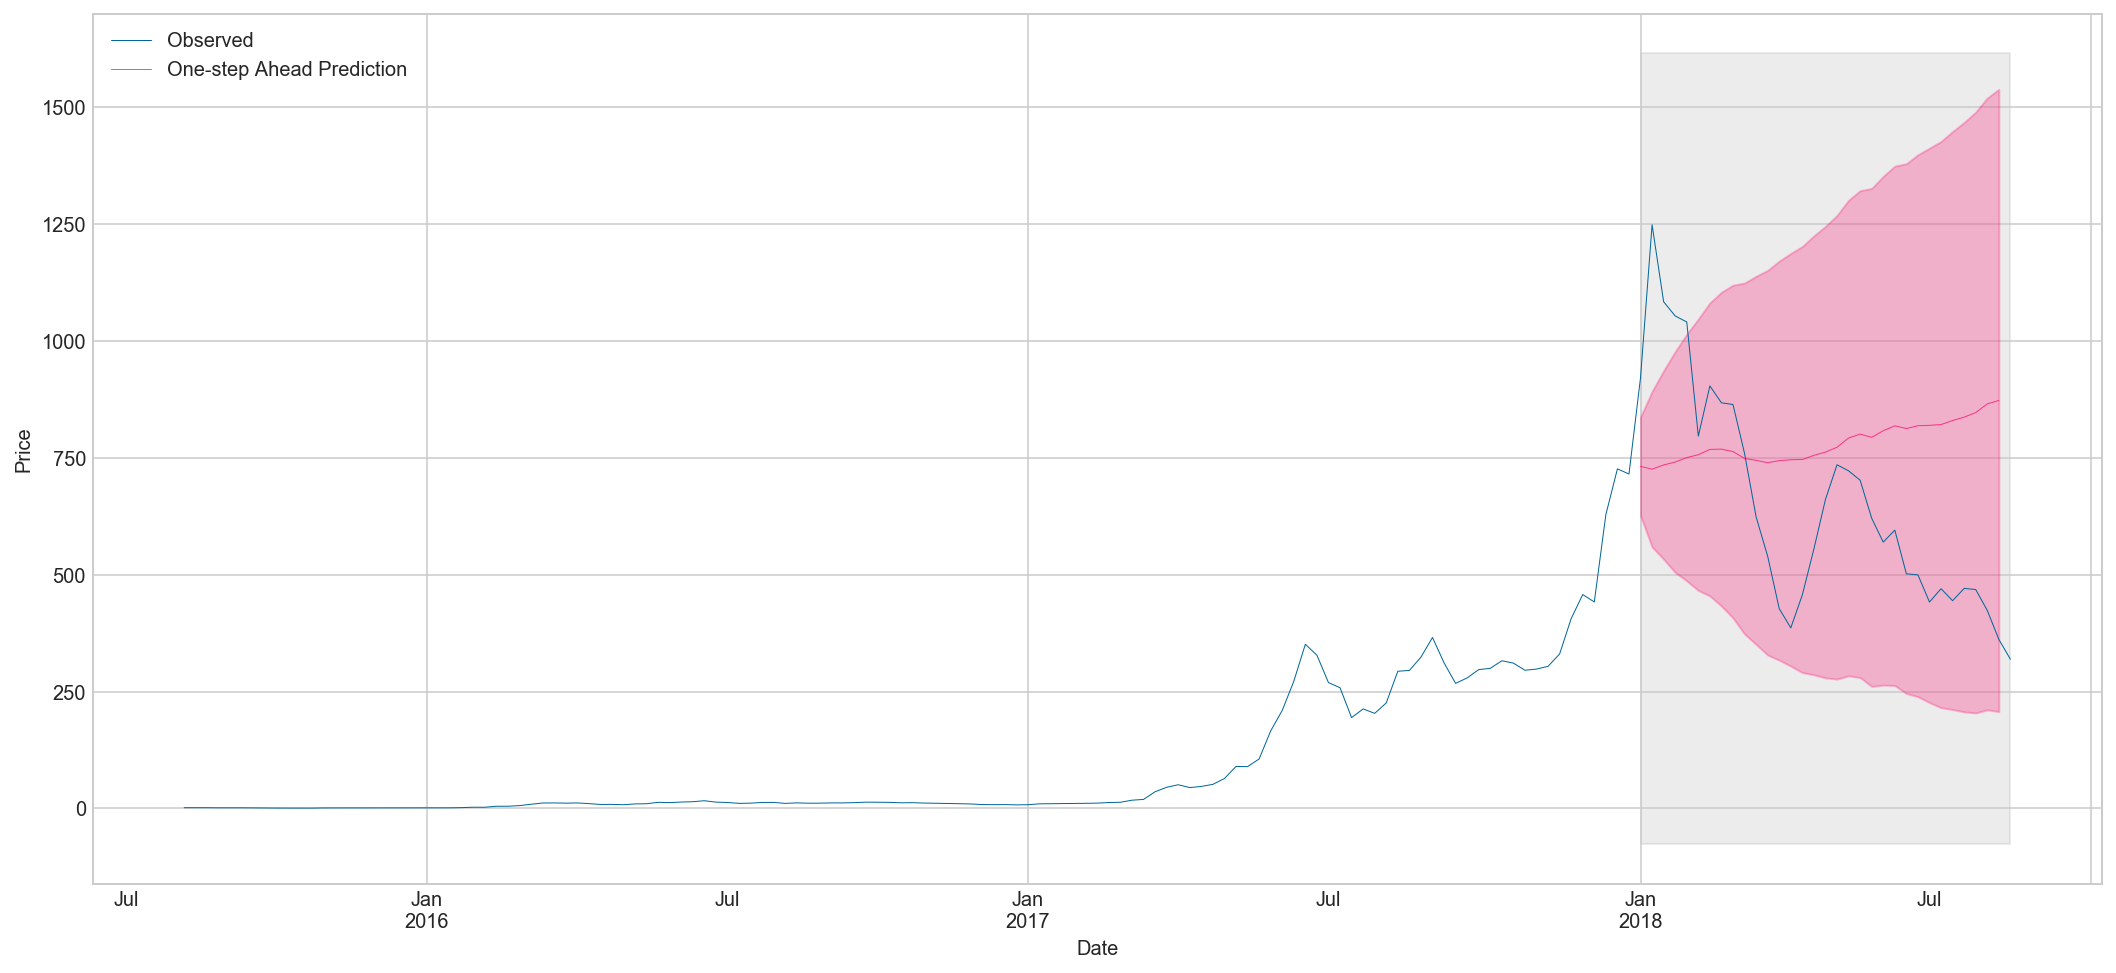

In [91]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(series,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2018-01-07'), 
                          end=pd.to_datetime('2018-08-12'),
                          dynamic=True, full_results=True)

pred_ci = pred.conf_int()

plt.figure(figsize=(18, 8))

# plot in-sample-prediction
ax = df_eth_weeklyclosemean['2015-08-09':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-07'), df_eth_weeklyclosemean.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend(loc='upper left')
plt.show()

The confidence interval is too wide, and the model shows a predicted steady climb but in actual fact, it went down.

In [92]:
import math
y_hat = pred.predicted_mean
y_true = df_eth_weeklyclosemean['2018-01-07':]
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))


Prediction quality: 80404.25 MSE (283.56 RMSE)


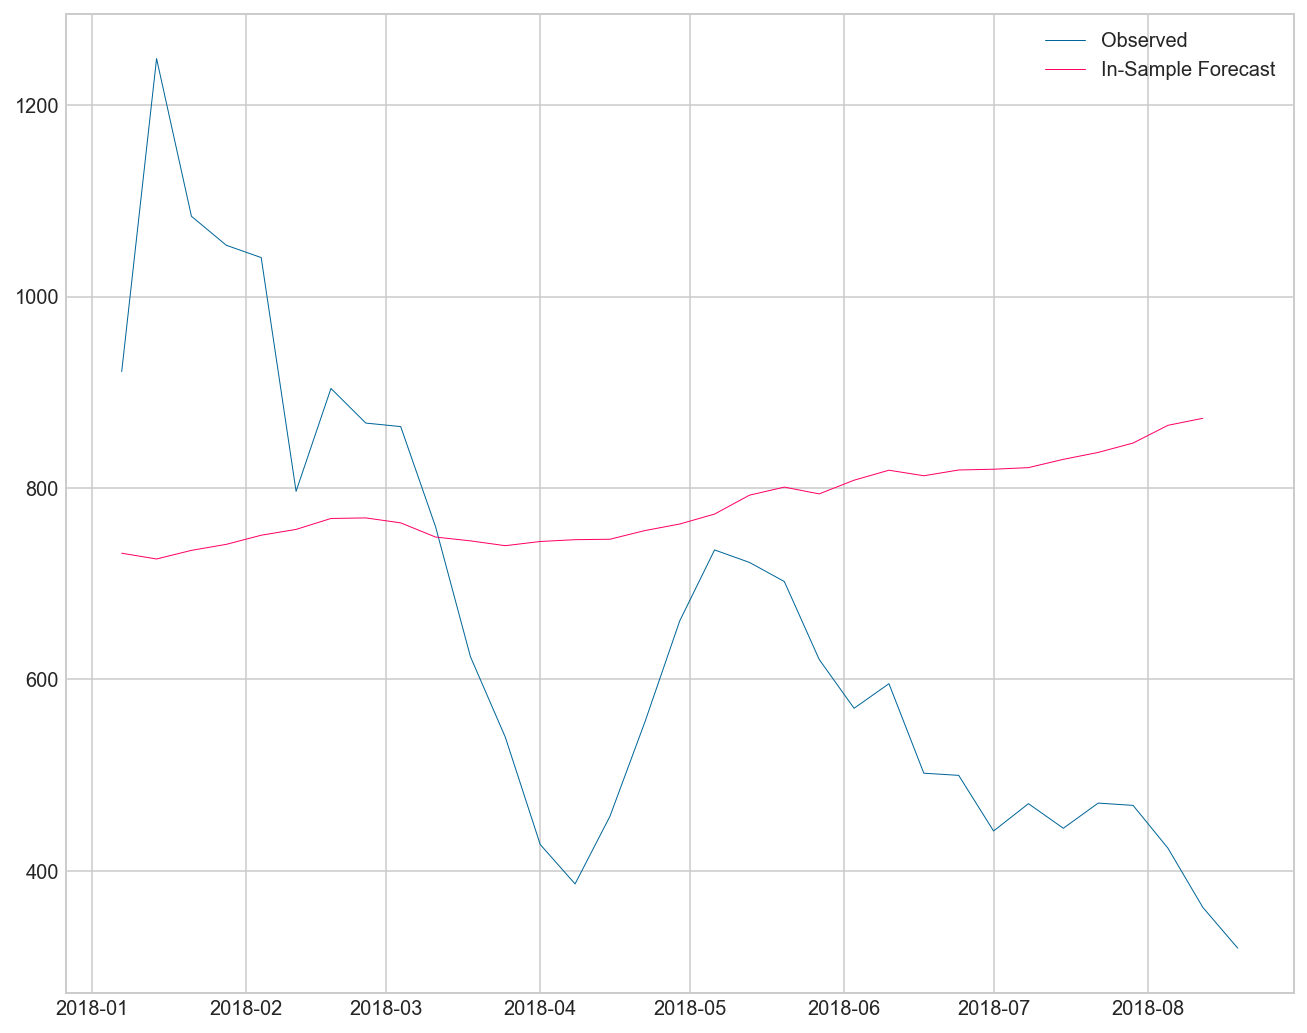

In [93]:
plt.plot(y_true, label='Observed', color='#006699')
plt.plot(y_hat, label='In-Sample Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend(loc='upper right');
plt.show()



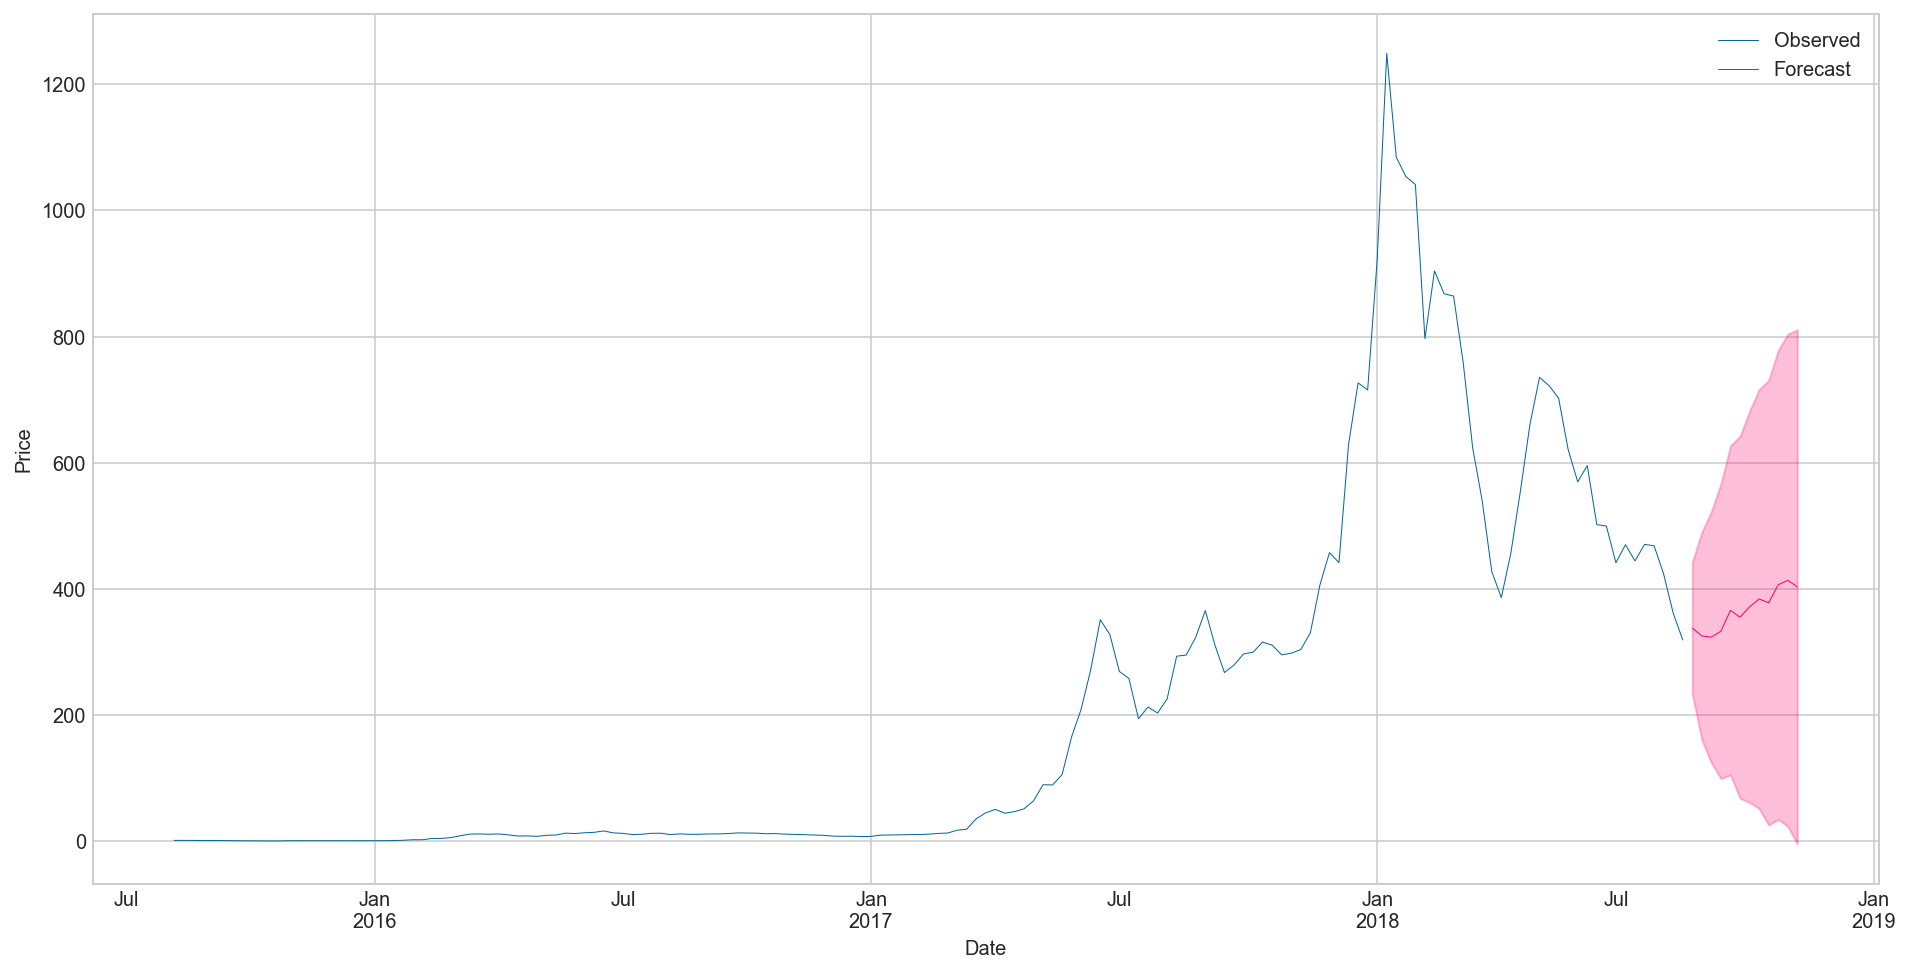

In [94]:
# get forecast 12 steps ahead in future
pred_uc = res.get_forecast(steps=12)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = df_eth_weeklyclosemean.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Price');
plt.legend(loc='upper right')
plt.show()

As we forecast further out into the future, it is natural for the model to become less confident in its values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

We also noticed the predicted values regularly mirror the previous values.